In [43]:
%load_ext autoreload
%autoreload 2
import sympy as sp
from scipy.optimize import minimize, Bounds
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dynamic Equation

In [44]:
(ddx_func, ddy_func, ddθ_func, ddϕ_func) = dynamics_eq()

# Planar Quadrotor - Direct Method

In [4]:
class PlanarQuadrotorDynamicsWithInvertedPendulum:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.g = 9.807         # gravity (m / s**2)
        self.mQ = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.IQ = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        # yapf: enable
        
        # Pendulum
        self.mp = self.mQ*4
        self.L = self.l*2
        self.Ip = self.mp*(self.L/2)**2
        

    def __call__(self, state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, y, θ, ϕ, dx, dy, dθ, dϕ = state
        T1, T2 = control
        return np.array([
            dx,
            dy,
            dθ,
            dϕ,
            ddx_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
            ddy_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
            ddθ_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
            ddϕ_func(self.Ip, self.mp, self.L, ϕ, dϕ, self.IQ, self.mQ, self.l, θ, dθ, T1, T2, self.g),
        ])

In [5]:
def pack_decision_variables(s, u, t_f = None, fixed_final_time = True):
    """Packs decision variables (final time, states, controls) into a 1D vector.
    
    Args:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    Returns:
        An array `z` of shape (1 + (N + 1) * s_dim + N * u_dim,).
    """
    if fixed_final_time:
        return np.concatenate([s.ravel(), u.ravel()])
    else:
        return np.concatenate([[t_f], s.ravel(), u.ravel()])

def unpack_decision_variables(z, fixed_final_time = True):
    """Unpacks a 1D vector into decision variables (final time, states, controls).
    
    Args:
        z: An array of shape (1 + (N + 1) * s_dim + N * u_dim,).
    Returns:
        t_f: Final time, a scalar.
        s: States, an array of shape (N + 1, s_dim).
        u: Controls, an array of shape (N, u_dim).
    """
    if fixed_final_time:
        s = z[0:(N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return s, u
    else:
        t_f = z[0]
        s = z[1:1 + (N + 1) * s_dim].reshape(N + 1, s_dim)
        u = z[-N * u_dim:].reshape(N, u_dim)
        return t_f, s, u

In [6]:
d2r = np.pi/180
r2d = 180/np.pi

In [46]:
N = 60  # Number of time discretization nodes (0, 1, ... N).
s_dim = 8  # State dimension;
u_dim = 2  # Control dimension; 
#t_f = 10  # fixed final time
#dt = t_f / N

s_0 = np.array([0, 0, 2*np.pi, np.pi-10*d2r, 0, 0, 0, 0])  # Initial state.
s_f = np.array([5, 5, 2*np.pi, np.pi, 2, 3, 0, 0])  # Final state.

t_f = 5  # fixed final time
dt = t_f/N

In [47]:
def optimize_trajectory():
    dynamics = PlanarQuadrotorDynamicsWithInvertedPendulum()
    
    def cost(z):
        s, u = unpack_decision_variables(z)
        return (dt) * np.sum(np.square(u))
    
    def constraints(z):
        states, controls = unpack_decision_variables(z)
        constraint_list = [states[0]-s_0, states[-1]-s_f]
        for i in range(N):
            constraint_list.append(states[i+1]-(states[i]+(dt)*dynamics(states[i], controls[i])))
        return np.concatenate(constraint_list)
    
    z_guess = pack_decision_variables(np.linspace(s_0, s_f, N+1), np.ones((N, u_dim)))
    z_iterates = [z_guess]
    
    #bnds = [(0, t_f)] + [(-np.inf,np.inf),(-np.inf,np.inf),(0,2*np.pi),(0,2*np.pi),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    bnds = [(-np.inf,np.inf),(-np.inf,np.inf),((315)*d2r,(585)*d2r),(0,2*np.pi),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf)]*(N+1) + [(0,np.inf),(0,np.inf)]*(N)
    
    result = minimize(cost,
                      z_guess,
                      method=None,
                      bounds=bnds,
                      constraints={'type':'eq','fun':constraints},
                      options={'maxiter':1000},
                      callback=lambda z:z_iterates.append(z))
    
    z_iterates = np.stack(z_iterates)
    z = result.x
    return (unpack_decision_variables(z))

In [48]:
s, u = optimize_trajectory()

In [49]:
t = np.linspace(0, t_f, N + 1)

In [50]:
animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=True)

In [51]:
ani = animate_planar_quad_with_inverted_pendulum(t, s[:,0], s[:,1], s[:,2], s[:,3], display_in_notebook=False)
ani = ani.save('planar_quad_with_inverted_pendulum_fix_final_time_4.mp4', writer='ffmpeg')

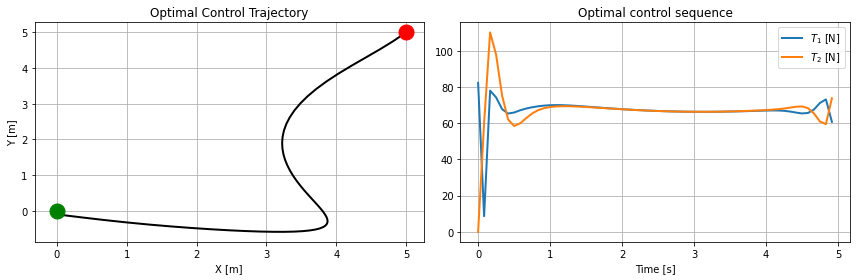

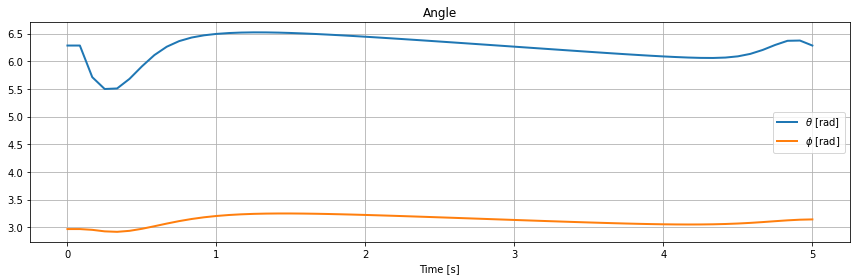

In [52]:
T1 = u[:, 0]
T2 = u[:, 1]

x = s[:, 0]
y = s[:, 1]
θ = s[:, 2]
ϕ = s[:, 3]

data = {'t_f': t, 's': s, 'u': u}
save_dict(data, f'data/optimal_control.pkl')
maybe_makedirs('plots')

# plotting
# plt.rc('font', weight='bold', size=16)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'k-', linewidth=2)
plt.grid(True)
plt.plot(0, 0, 'go', markerfacecolor='green', markersize=15) # start position
plt.plot(5, 5, 'ro', markerfacecolor='red', markersize=15) # end position
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
#plt.axis([-1, 6, -1, 6])
plt.title(f'Optimal Control Trajectory')


plt.subplot(1, 2, 2)
plt.plot(t[:-1], T1, linewidth=2)
plt.plot(t[:-1], T2, linewidth=2)
plt.grid(True)
plt.xlabel('Time [s]')
plt.legend([r'$T_1$ [N]', r'$T_2$ [N]'], loc='best')
plt.title(f'Optimal control sequence')
plt.tight_layout()
plt.savefig(f'plots/optimal_control_fix_time_2.png')
plt.show()


plt.figure(figsize=(12, 4))
#plt.subplot(1, 2, 2)
plt.plot(t, θ, linewidth=2)
plt.plot(t, ϕ, linewidth=2)
plt.grid(True)
plt.xlabel('Time [s]')
plt.legend([r'$\theta$ [rad]', r'$\phi$ [rad]'], loc='best')
plt.title(f'Angle')
plt.tight_layout()
plt.savefig(f'plots/angle_fix_time_2.png')
plt.show()